In [1]:
import os
os.chdir(os.path.abspath(".."))

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from dataio import load_metadataset, load_accs
from metamodel import build_baseline, build_classification_topline

from sklearn.feature_selection import SelectFpr, VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

from MCM import MCM

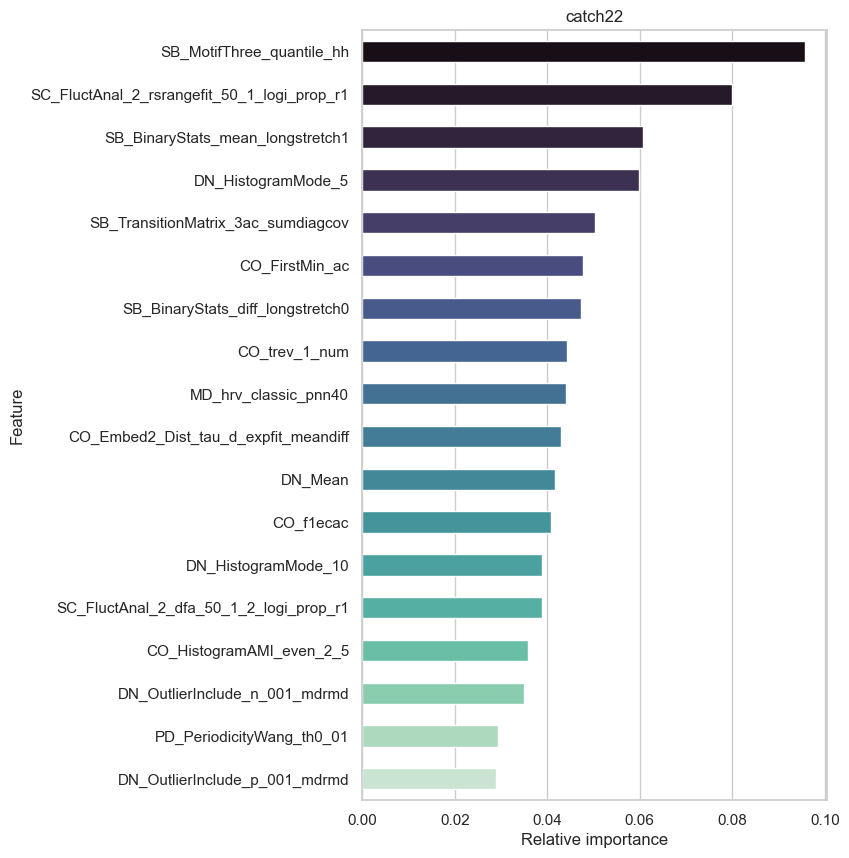

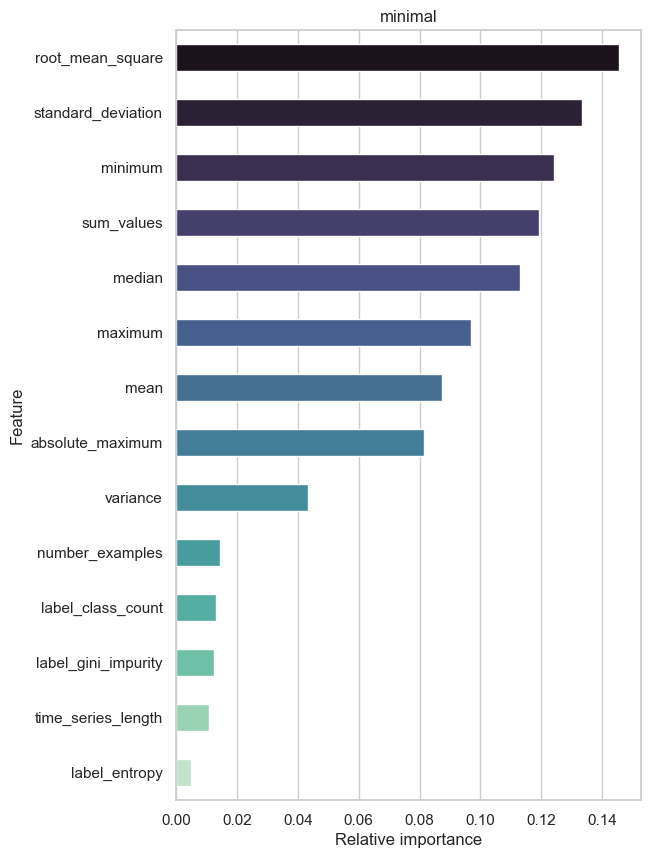

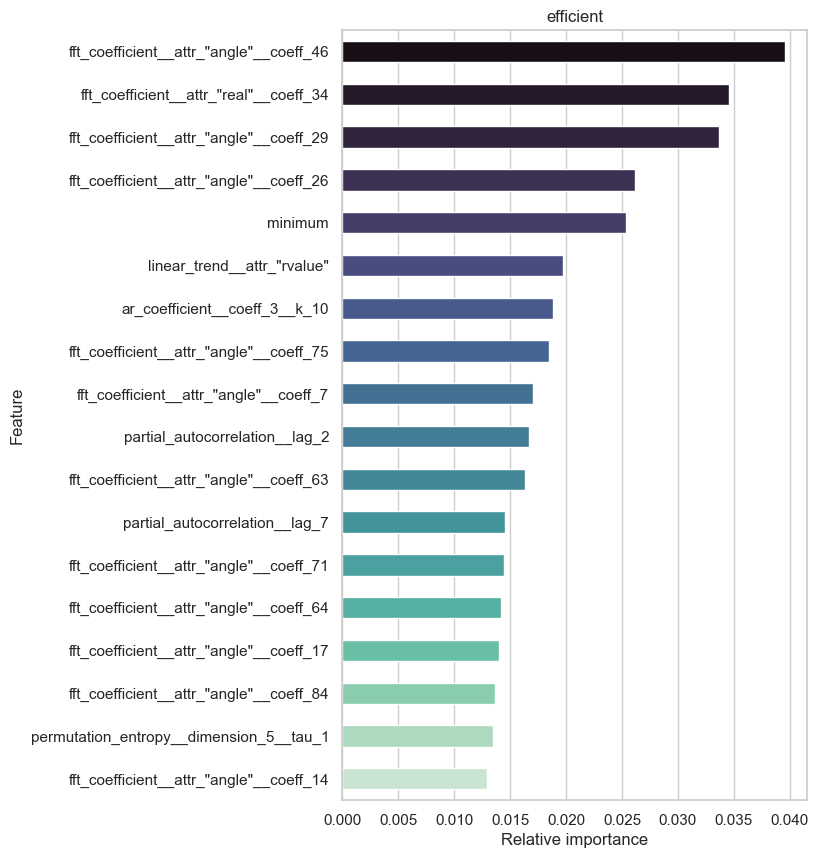

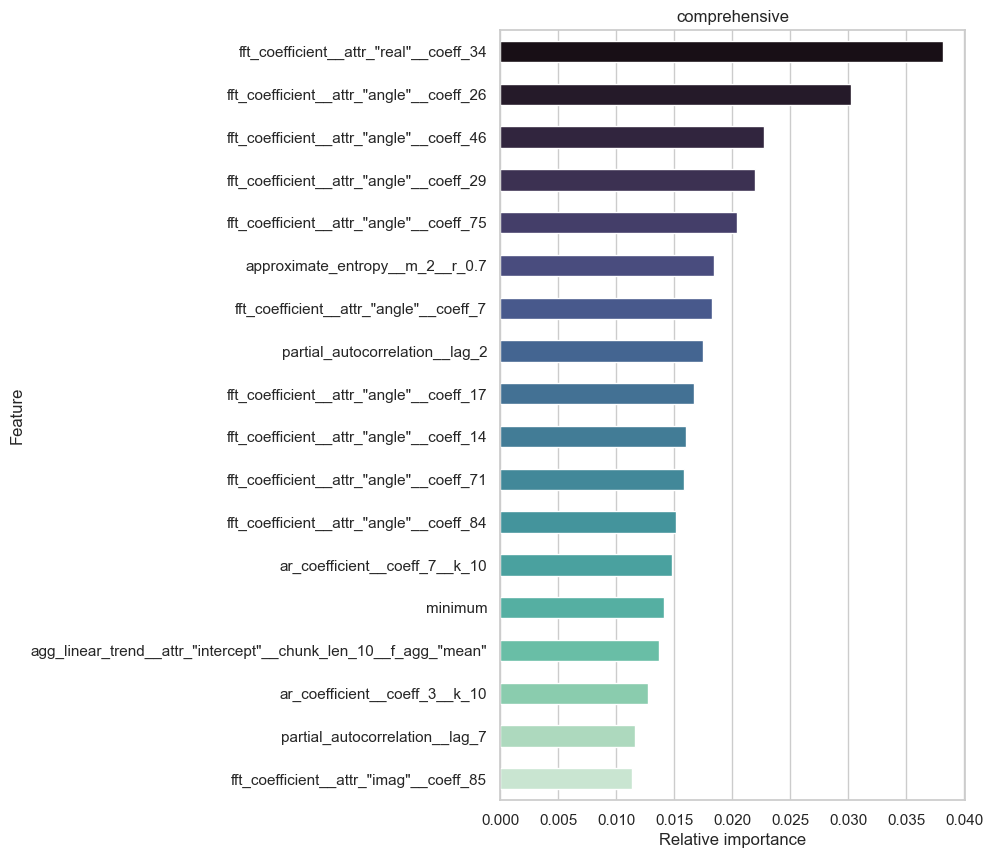

In [3]:
sns.set_theme(style="whitegrid")

feature_set_importances = dict()

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    meta_X, meta_y = load_metadataset(feature_set, problem_type="classification")
    y_encoder = LabelEncoder().fit(meta_y)
    meta_y_encoded = y_encoder.transform(meta_y)

    xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
    feature_importances = xgb.feature_importances_
    
    importance_map = dict()
    for fname, fimp in zip(meta_X.columns, feature_importances):
        fname_split = fname.split("_")
        if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
            fname_proper = "_".join(fname_split[1:])
            importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
        else:
            importance_map[fname] = fimp + importance_map.get(fname, 0.)

    imps = np.array(list(importance_map.values()))
    names = np.array(list(importance_map.keys()))
    order = np.argsort(-imps)

    feature_set_importances[feature_set] = {
        "name": names[order],
        "importance": imps[order]
    }

n_features = 18
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    fig, ax = plt.subplots(figsize=(6, 10))

    sns.barplot(
        x=feature_set_importances[feature_set]["importance"][:n_features],
        y=feature_set_importances[feature_set]["name"][:n_features],
        palette="mako",
        width=0.5,
        ax=ax
    )
    ax.set_xlabel("Relative importance")
    ax.set_ylabel("Feature")
    ax.set_title(feature_set)

    plt.show()

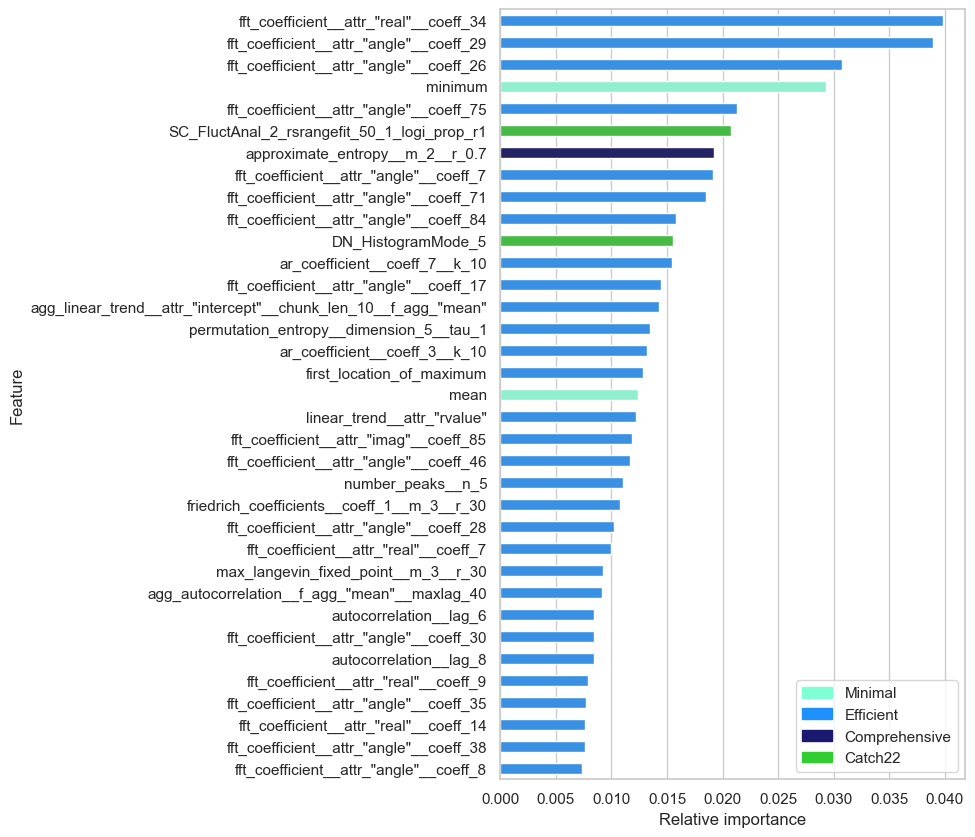

In [6]:
meta_X_tsfresh, meta_y = load_metadataset("comprehensive", "classification")
meta_X_catch22, _ = load_metadataset("catch22", "classification")
meta_X = pd.concat([meta_X_tsfresh, meta_X_catch22], axis=1)
meta_X = meta_X.T.drop_duplicates().T

y_encoder = LabelEncoder().fit(meta_y)
meta_y_encoded = y_encoder.transform(meta_y)

xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
feature_importances = xgb.feature_importances_

importance_map = dict()
for fname, fimp in zip(meta_X.columns, feature_importances):
    fname_split = fname.split("_")
    if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
        fname_proper = "_".join(fname_split[1:])
        importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
    else:
        importance_map[fname] = fimp + importance_map.get(fname, 0.)

imps = np.array(list(importance_map.values()))
names = np.array(list(importance_map.keys()))
order = np.argsort(-imps)

hue = list()
for name in names:
    if name in ["number_examples", "time_series_length"]:
        hue.append("General")
    elif name.startswith("label_"):
        hue.append("Label")
    elif name in feature_set_importances["catch22"]["name"]:
        hue.append("Catch22")
    elif name in feature_set_importances["minimal"]["name"]:
        hue.append("Minimal")
    elif name in feature_set_importances["efficient"]["name"]:
        hue.append("Efficient")
    else:
        hue.append("Comprehensive")
hue = np.array(hue)
colors = {
    "Minimal": "aquamarine",
    "Efficient": "dodgerblue",
    "Comprehensive": "midnightblue",
    "Catch22": "limegreen",
    #"General": "red",
    #"Label": "magenta"
}

n_features = 35
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(
    x=imps[order][:n_features],
    y=names[order][:n_features],
    width=0.5,
    palette=[colors[h] for h in hue[order][:n_features]],
    ax=ax
)
ax.set_xlabel("Relative importance")
ax.set_ylabel("Feature")
ax.legend(
    [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in colors.keys()],
    colors.keys()
)

plt.show()

In [7]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    accs = np.empty(5)
    for i in range(5):
        results = pd.read_csv(f"./results/classification_label_{feature_set}_xgb_{i+1}.csv")
        accs[i] = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * np.mean(accs):.5f}%")

--- Best estimator accuracies ---
catch22: 35.21127%
minimal: 30.98592%
efficient: 30.98592%
comprehensive: 27.46479%


In [11]:
results = dict()
accs = load_accs()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    acc = None
    for i in range(5):
        res = pd.read_csv(f"./results/classification_label_{feature_set}_xgb_{i+1}.csv")
        if acc is None:
            acc = res["acc"]
        else:
            acc = acc + res["acc"]
    acc = acc / 5

    results[feature_set] = acc

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(accs)
results["topline"] = build_classification_topline(accs) + 1e-15

results = pd.DataFrame(results).set_index("datasets")
results

,catch22,minimal,efficient,comprehensive,baseline,topline
datasets,,,,,,
ACSF1,0.843667,0.826667,0.843667,0.843667,0.803125,0.843667
AconityMINIPrinterLargeEq,0.954673,0.954673,0.954673,0.954673,0.948582,0.965512
AconityMINIPrinterSmallEq,0.972831,0.972831,0.972831,0.972831,0.973816,0.977968
Adiac,0.824467,0.824467,0.824467,0.824467,0.792647,0.824467
AllGestureWiimoteXEq,0.818333,0.818333,0.765286,0.765286,0.734196,0.818333
...,...,...,...,...,...,...
Wine,0.957407,0.947531,0.856173,0.856173,0.912346,0.957407
WordSynonyms,0.786886,0.786886,0.786886,0.752090,0.738532,0.786886
Worms,0.760173,0.760173,0.760173,0.760173,0.742749,0.780952


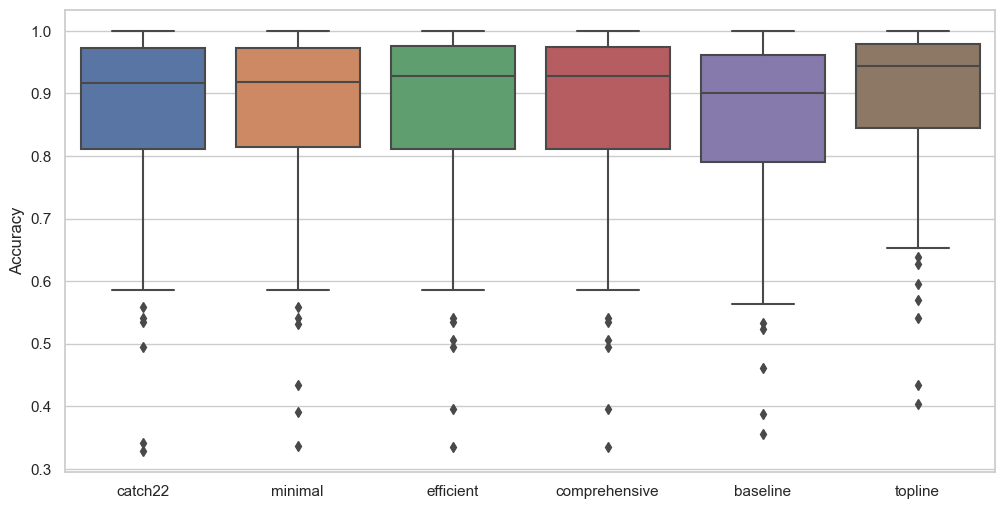

In [13]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=results, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Accuracy")

plt.show()

Processing topline, baseline:   0%|          | 0/6 [00:00<?, ?it/s]       


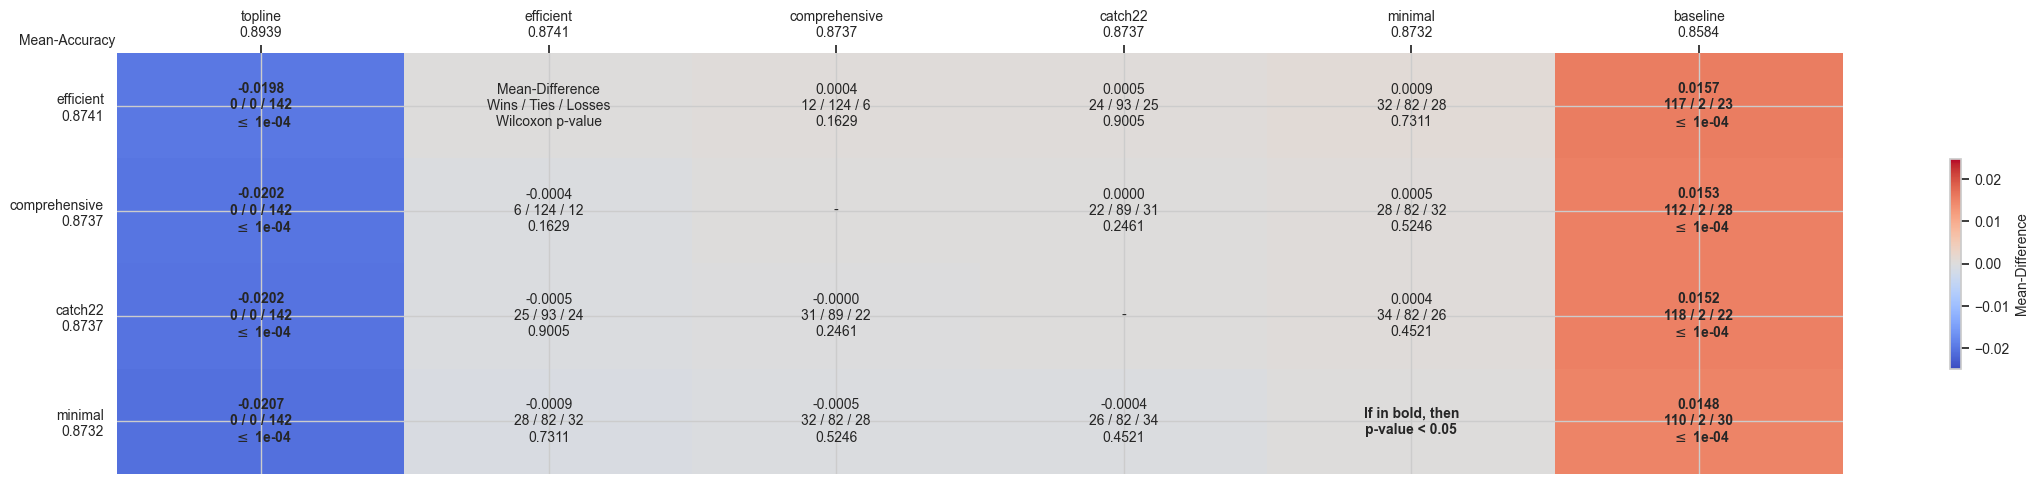

In [14]:
MCM.compare(
    df_results=results,
    output_dir="results/",
    used_statistic="Accuracy",
    order_WinTieLoss="higher",
    order_better="decreasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm",
    excluded_row_comparates=["baseline", "topline"],
)

In [10]:
print("--- Metamodel accuracies ---")
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/regression_label_catch22_{model}.csv")
    print(f"{model}: {100 * accuracy_score(res['best_estimator'], res['predicted_estimator']):.5f}%")

for model in ["rf", "xgb"]:
    acc = 0.
    for i in range(5):
        res = pd.read_csv(f"results/regression_label_catch22_{model}_{i+1}.csv")
        acc += accuracy_score(res['best_estimator'], res['predicted_estimator'])
    acc /= 5
    print(f"{model}: {100 * acc:.5f}%")

--- Metamodel accuracies ---
svm: 37.09677%
nb: 11.29032%
1nn: 30.64516%
5nn: 25.80645%
rf: 36.12903%
xgb: 32.25806%


In [53]:
results = dict()
for model in ["svm", "nb", "1nn", "5nn"]:
    res = pd.read_csv(f"results/regression_label_catch22_{model}.csv")
    results[model] = res["rmse"]

for model in ["rf", "xgb"]:
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"results/regression_label_catch22_{model}_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5
    results[model] = rmse

rmses = load_rmses()
results["datasets"] = rmses.columns

results = pd.DataFrame(results).set_index("datasets")
results_normalized = ((results.T - results.T.mean()) / results.T.std()).T
results_normalized

,svm,nb,1nn,5nn,rf,xgb
datasets,,,,,,
AcousticContaminationMadrid-no-missing,-0.377455,1.208635,1.208635,-0.377455,-1.284906,-0.377455
AluminiumConcentration,0.390436,-2.039982,0.390436,0.390436,0.478239,0.390436
AppliancesEnergy,-0.499556,-0.002218,2.000442,-0.499556,-0.499556,-0.499556
BIDMC32HR,-0.408248,2.041241,-0.408248,-0.408248,-0.408248,-0.408248
BIDMC32RR,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
TetuanEnergyConsumption,-0.584474,1.877093,-0.567627,-0.567627,0.410261,-0.567627
VentilatorPressure,-0.557431,2.003258,-0.557431,-0.557431,-0.165482,-0.165482
WaveDataTension,-0.617213,1.697337,-0.617213,-0.617213,0.771517,-0.617213


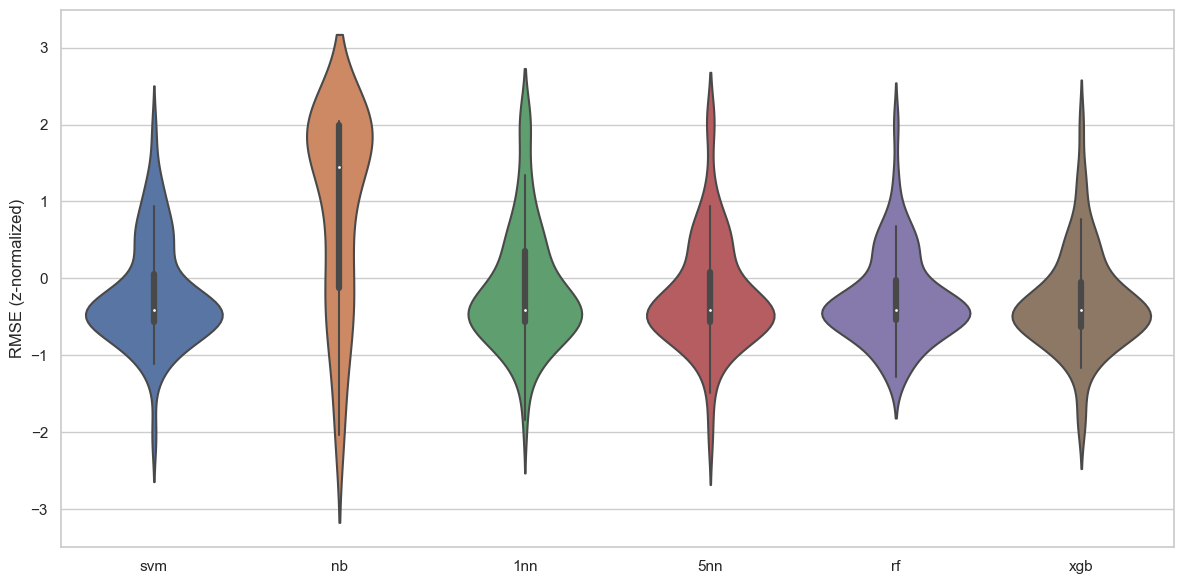

In [54]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.violinplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE (z-normalized)")

plt.show()

Processing xgb, rf:   0%|          | 0/6 [00:00<?, ?it/s] 


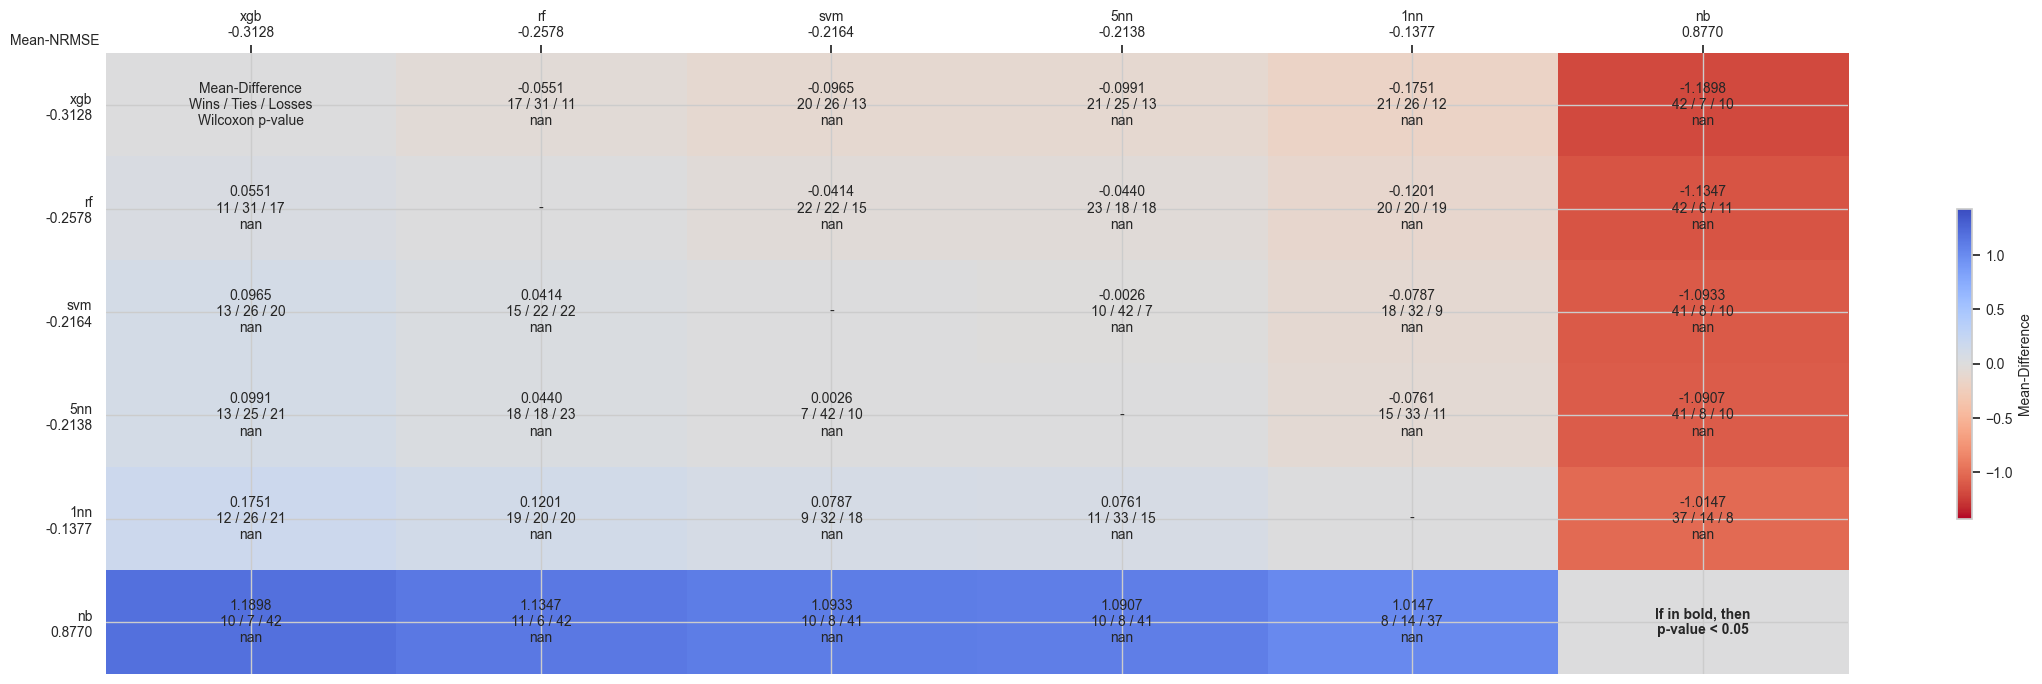

In [13]:
MCM.compare(
    df_results=results_normalized,
    output_dir="results/",
    used_statistic="NRMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm_r",
    colorbar_orientation="vertical",
)

Processing DrCIF, TSF:   0%|          | 0/10 [00:00<?, ?it/s]        

Processing MetaL-RaTS-RandF, MetaL-RaTS-XGB:   0%|          | 0/10 [00:00<?, ?it/s]


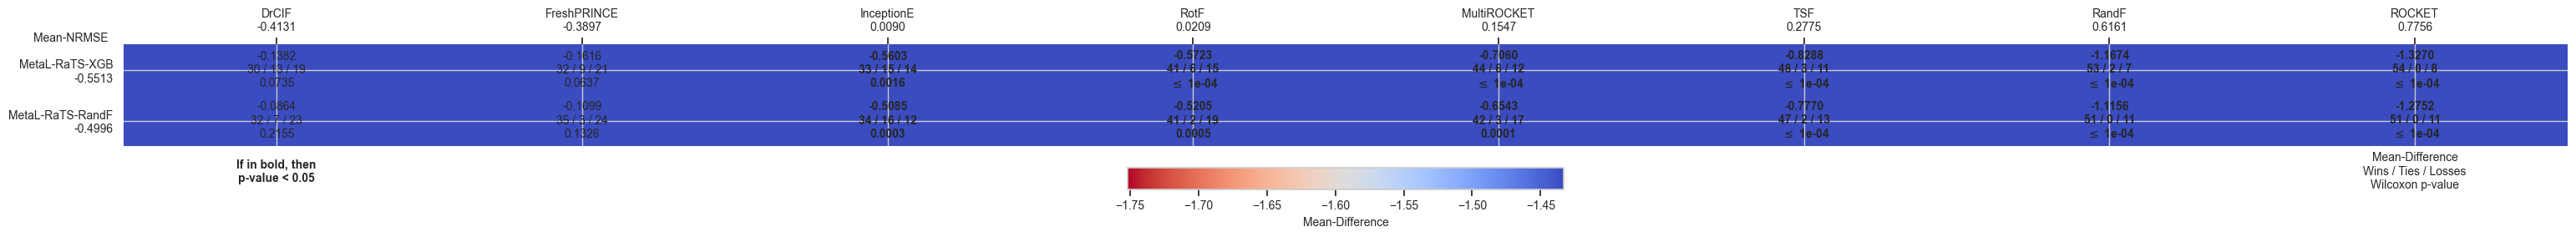

In [60]:
comparison = load_rmses().T
comparison["MetaL-RaTS-XGB"] = results["xgb"]
comparison["MetaL-RaTS-RandF"] = results["rf"]
comparison_normalized = ((comparison.T - comparison.T.mean()) / comparison.T.std()).T

MCM.compare(
    df_results=comparison_normalized,
    output_dir="results/",
    used_statistic="NRMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm_r",
    row_comparates=["MetaL-RaTS-XGB", "MetaL-RaTS-RandF"],
    excluded_col_comparates=["MetaL-RaTS-XGB", "MetaL-RaTS-RandF"],
)